In [71]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [72]:
# 데이터 불러오기
df = pd.read_csv('../data/data-02-stock_daily.csv')

# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
df = df[::-1]
train_size = int(len(df) * 0.7)
train_set = df[0:train_size]
test_set = df[train_size - seq_length:]

In [73]:
# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1] = scaler_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])

/var/folders/hx/wdyskqm96nv4msmwh8bfw7w80000gp/T/ipykernel_39105/2659875947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
/var/folders/hx/wdyskqm96nv4msmwh8bfw7w80000gp/T/ipykernel_39105/2659875947.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])
/var/folders/hx/wdyskqm96nv4msmwh8bfw7w80000gp/T/ipykernel_39105/2659875947.py:12: SettingWithCopyWarning: 
A value is try

In [74]:
from torch.utils.data import TensorDataset  # 텐서데이터셋
from torch.utils.data import DataLoader  # 데이터로더


# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)


trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,
                        drop_last=True)

In [81]:
# 설정값
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
nb_epochs = 100


class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

        # 학습 초기화를 위한 함수

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = x[:, -1]
        z = self.fc(x)
        return z

In [83]:
def train_model(model, train_df, num_epochs=None, lr=None, verbose=10, patience=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples

            # seq별 hidden state reset
            model.reset_hidden_state()

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss / total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):

            # loss가 커졌다면 early stop
            if train_hist[epoch - patience] < train_hist[epoch]:
                print('\n Early Stopping')

                break

    return model.eval(), train_hist

In [84]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model, train_hist = train_model(net, dataloader, num_epochs=nb_epochs, lr=learning_rate, verbose=20, patience=10)

KeyboardInterrupt: 

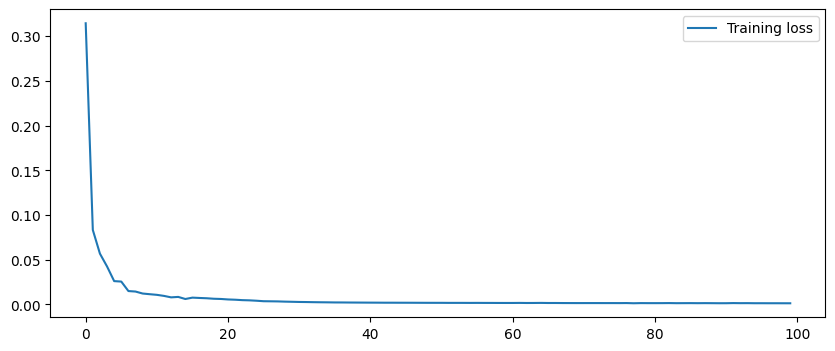

In [78]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()